## Importing libraries and datasets

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Training data
train = pd.read_csv('titanic/train.csv')
#Testing data
test = pd.read_csv('titanic/test.csv')

## Feature Engineering

In [27]:
from sklearn.preprocessing import LabelEncoder

def preprocess(df):
    df = df.copy()
    # Extract Title
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+).', expand=False)

    # Fill missing values
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

    # Encode categorical features
    label = LabelEncoder()
    for col in ['Sex', 'Embarked', 'Title']:
        df[col] = label.fit_transform(df[col])

    # Drop irrelevant columns
    df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True, errors='ignore')
    
    return df

train_processed = preprocess(train)
test_processed = preprocess(test)

In [29]:
x = train_processed.drop('Survived', axis=1)
y = train_processed['Survived']

## 1. Decision Tree Classifier

In [33]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini',max_depth=3, min_samples_split=5,random_state=42)
dtree.fit(x, y)
test_predict = dtree.predict(test_processed)

In [35]:
from sklearn.tree import DecisionTreeClassifier
dtree1 = DecisionTreeClassifier(criterion='entropy',max_depth=3, min_samples_split=5,random_state=42)
dtree1.fit(x, y)
test_predict = dtree1.predict(test_processed)

In [42]:
from sklearn.metrics import accuracy_score

## 2. Cross Validation

In [38]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(dtree, x, y, cv=5)
print("Cross-validation accuracy (Decision Tree):", cv_scores.mean())

Cross-validation accuracy (Decision Tree): 0.8091959073504487


In [56]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(dtree1, x, y, cv=5)
print("Cross-validation accuracy (Decision Tree - Entropy):", cv_scores.mean())

Cross-validation accuracy (Decision Tree - Entropy): 0.8148076078086749


## 3. Bagging Classifier

In [52]:
from sklearn.ensemble import BaggingClassifier
bagged = BaggingClassifier(estimator = dtree,  n_estimators=100, bootstrap=True, random_state=42)
bagged.fit(x, y)
print("Bagging Accuracy:", bagged.score(test_processed, bagged.predict(test_processed)))

Bagging Accuracy: 1.0


## 4. Random Forest Classifier

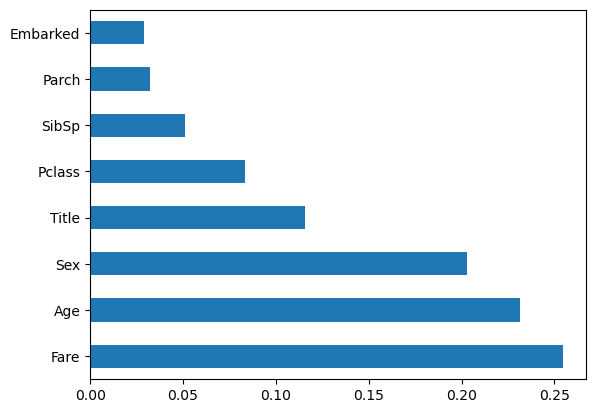

In [59]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
rf.fit(x, y)

importances = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
importances.plot(kind='barh')
plt.show()

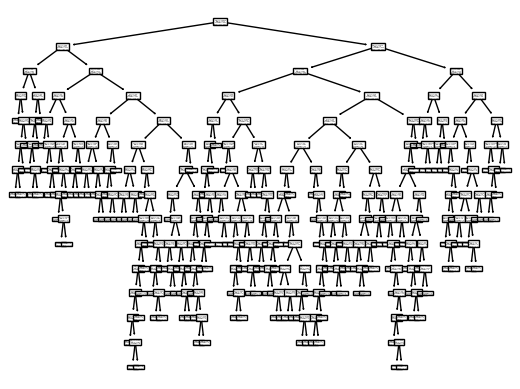

In [65]:
from sklearn.tree import plot_tree
import pydotplus
from IPython.display import Image

# Visualize tree number 0
estimator = rf.estimators_[0]

# Export as dot file
tree = plot_tree(estimator)

## 5. Hyperparameter Tuning

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(x, y)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_
best_score = grid.best_score_
print("Score: ", grid.score(x, y))

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Score:  0.8552188552188552


## 6. Model Evaluation

In [77]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, test_processed, best_model.predict(test_processed), cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Average CV Accuracy:", cv_scores.mean())


Cross-Validation Accuracy Scores: [0.94047619 0.9047619  0.94047619 0.92771084 0.92771084]
Average CV Accuracy: 0.9282271944922547


## 7. Save the model

In [80]:
import pickle

with open('best_titanic_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)